## Sentiment analysis
-----
### Importing the cleaned data
---

In [1]:
%store -r game_df_cleaned
%store -r swords_df_cleaned

%store -r game_text_cleaned
%store -r swords_text_cleaned

In [2]:
!pip install afinn

Defaulting to user installation because normal site-packages is not writeable


In [9]:
from afinn import Afinn as Afinn
import re
from siuba import *
import pandas as pd
from wordcloud import *

In [99]:
afinn = Afinn()

game_text_str = ""
for _list in game_text_cleaned:
    for string in _list:
        game_text_str += string + ' '

game_df_cleaned = pd.DataFrame({
    "word": game_text_str.split()
})

swords_text_str = ""
for _list in swords_text_cleaned:
    for string in _list:
        swords_text_str += string + ' '

swords_df_cleaned = pd.DataFrame({
    "word": swords_text_str.split()
})

word_scores_swords = [afinn.score(word_) for word_ in swords_df_cleaned['word']]
swords_df_cleaned = swords_df_cleaned.assign(word_score = word_scores_swords)
# print(swords_df_cleaned)

word_scores_game = [afinn.score(word) for word in game_df_cleaned['word']]
game_df_cleaned = game_df_cleaned.assign(word_score = word_scores_game)
# print(game_df_cleaned)

### Function to break first book into chapters
------
#### Chapter 0 ----> PROLOGUE

In [5]:
chapters_first_book = ["BRAN", "CATELYN", "DAENERYS", "EDDARD", "JON", "ARYA", "TYRION", "SANSA"]
chapters_second_book = ["JAIME", "DAVOS", "SAMWELL", "BRAN", "CATELYN", "DAENERYS", "JON", "ARYA", "TYRION", "SANSA"]

# CHAPTER 0  -------> PROLOGUE
def select_chapter(dataframe, chapters):
    chapter_list = []
    curr_chapter = 0
    flag = False
    flag_epilogue = 0
    for index, row in dataframe.iterrows():
        if flag:
            curr_chapter = curr_chapter
        elif re.search("HOUSE", row['word']) and "SAMWELL" not in chapters:
            flag = True
        elif re.search("EPILOGUE", row['word']):
            flag_epilogue += 1
            if flag_epilogue > 1:
                flag = True
        elif row['word'] in chapters:
            curr_chapter += 1
        chapter_list.append(curr_chapter)
    return chapter_list


### Breaking first book in chapters ( A Game of Thrones )
---

In [109]:
game_df_cleaned = game_df_cleaned.assign(chapter = select_chapter(game_df_cleaned, chapters_first_book))
game_df_cleaned.head(150000)

,word,word_score,chapter
0,GAME,0.0,0
1,OF,0.0,0
2,THRONES,0.0,0
3,Book,0.0,0
4,Song,0.0,0
...,...,...,...
149995,Flint,0.0,72
149996,Smalljon,0.0,72
149997,Umber,0.0,72
149998,exchanged,0.0,72


### Breaking the second book in chapters ( A Storm of Swords )
---

In [110]:
swords_df_cleaned = swords_df_cleaned.assign(chapter = select_chapter(swords_df_cleaned, chapters_second_book))
swords_df_cleaned.head(150000)

,word,word_score,chapter
0,STORM,0.0,0
1,OF,0.0,0
2,SWORDS,0.0,0
3,Book,0.0,0
4,Song,0.0,0
...,...,...,...
149995,held,0.0,80
149996,tongue,0.0,80
149997,Dany,0.0,80
149998,swept,0.0,80


### Chapter Scores for Storm of Swords (3rd book)
---

In [107]:
swords_df_cleaned_grouped = group_by(swords_df_cleaned, 'chapter')
summarized_ss_df_swords = summarize(swords_df_cleaned_grouped, chapter_score = _.word_score.sum())
summarized_ss_df_swords.head()

,chapter,chapter_score
0,0,-238.0
1,1,-113.0
2,2,-14.0
3,3,-94.0
4,4,-69.0


### Chapter Scores for A Game of Thrones (1st book)
---

In [108]:
game_df_cleaned_grouped = group_by(game_df_cleaned, 'chapter')
summarized_ss_df = summarize(game_df_cleaned_grouped, chapter_score = _.word_score.sum())
summarized_ss_df.head()

,chapter,chapter_score
0,0,-56.0
1,1,-90.0
2,2,2.0
3,3,6.0
4,4,-9.0


### Generating a WordCloud based on chapters 50 & 51 (The Red Wedding)
----

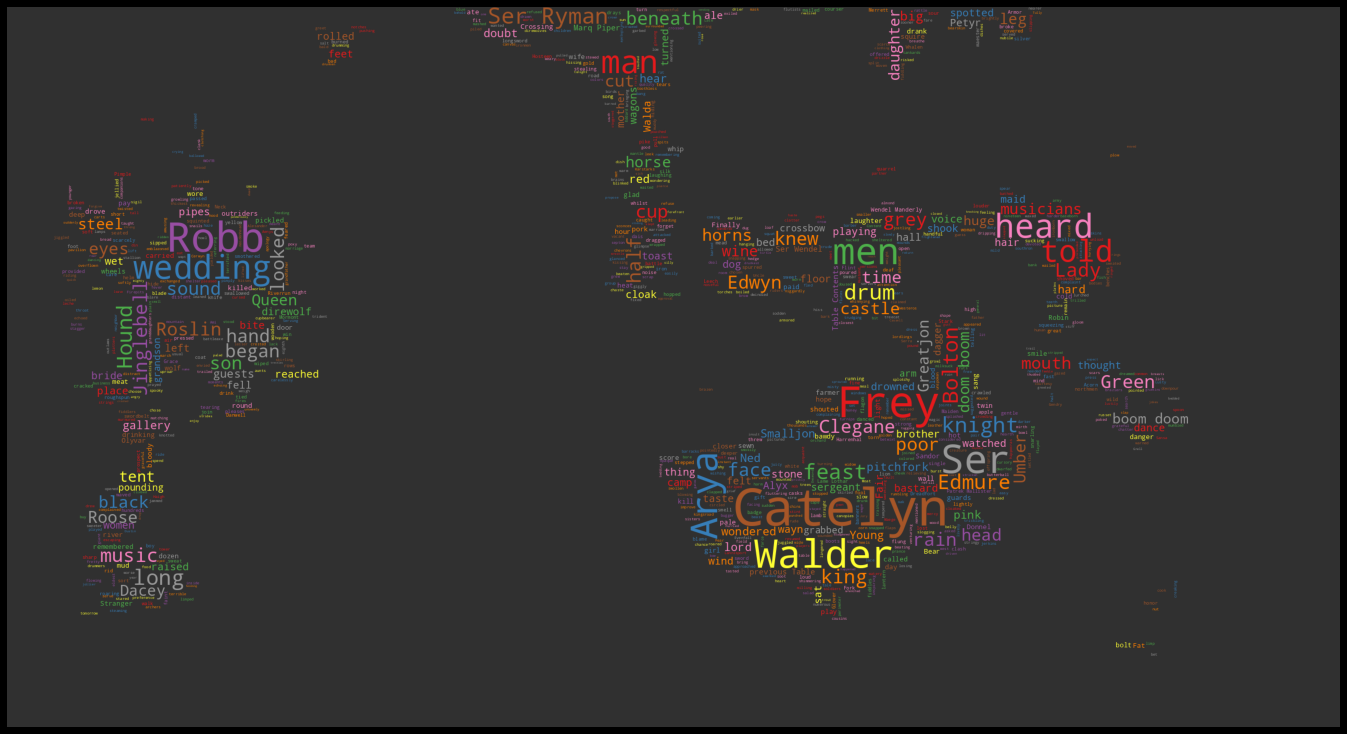

In [28]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("../resources/map.png"))
mask[mask == 0] = 255

red_wedding = swords_df_cleaned[ (swords_df_cleaned['chapter'] >= 50) & (swords_df_cleaned['chapter'] <= 51) ]
text_str = ""
for str in red_wedding['word']:
    text_str += str + " "

cloudy_cloud = WordCloud(background_color="#303030", width=1600, height=800, colormap='Set1', max_words=1000, mask=mask).generate(text_str)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(cloudy_cloud)
plt.axis("off")
plt.tight_layout(pad=0)


